# ML applied to microgrid sizing

### Load data

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

case_name = "mg_sizing_dataset_with_loc"
df = pd.read_csv("results/" + case_name + ".csv", sep=";|,", engine="python", index_col='index')

features = ["longitude", "latitude", "off-grid","avg_peak_winter","avg_peak_spring","avg_peak_summer","avg_peak_autumn","avg_base_winter","avg_base_spring","avg_base_summer","avg_base_autumn"]
targets = ["PV","BAT","RBAT","INV","GEN","NPV"]
df = df.loc[df['peak_load'] == 1]
one_hot = pd.get_dummies(df['location'])
one_hot2 = pd.get_dummies(df['name'])
df = df.drop('location',axis = 1)
df = df.drop('name',axis = 1)
df = df.drop('elevation',axis = 1)
df = df.drop('peak_load',axis = 1)
df = df.drop('purchase_price',axis = 1)
df = df.join(one_hot)
df = df.join(one_hot2)
#df['latitude'] = df['latitude'].abs()
# X = df[features]
y = df[targets]
X = df.drop(targets, axis=1)
features = X.columns
# Commentaire: Peak load retiré des features car induit une forte dispersion du sizing et donc des erreurs de prédictions importantes. 
# Solution: Etablir le modèle avec un peak de 1 et multiplier le sizing de sortie par le peak.

### Scale the data

In [39]:
# from sklearn.preprocessing import StandardScaler
# Xscaler = StandardScaler()
# yscaler = StandardScaler()
# Xscaler.fit(X)
# X_scale = pd.DataFrame(Xscaler.transform(X), index=X.index, columns=X.columns)
# yscaler.fit(y)
# y_scale = pd.DataFrame(yscaler.transform(y), index=y.index, columns=y.columns)


## 1. Feature analysis
### 1.1 Correlation between features and targets

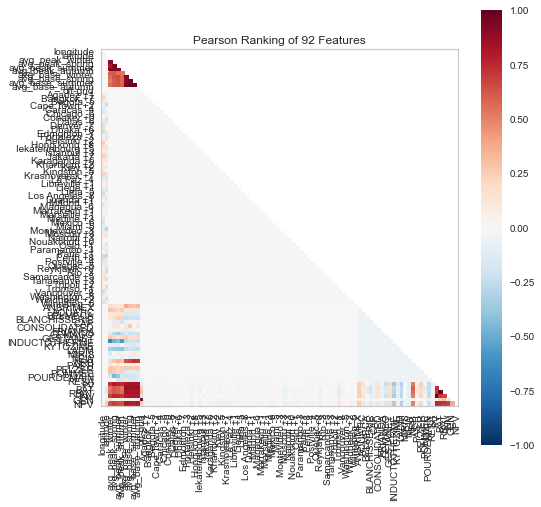

In [40]:
%matplotlib inline
from yellowbrick.features import rank1d, rank2d
 
_, axes = plt.subplots(nrows=1, figsize=(8,8))
# rank1d(X, ax=axes[0], show=False)
rank2d(pd.concat([X, y], axis=1), ax=axes)
plt.show()

#Commentaire: -Lattitude et longitude ont peu d'impact sur le sizing. Pourquoi ? irradiation ?
#             -Les base et peak avg fortement corrélés -> remplacer les 4 valeurs par leur moyenne ?

### 1.2 Detailed by target

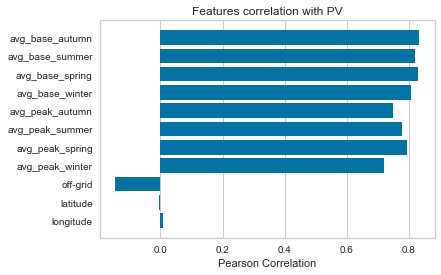

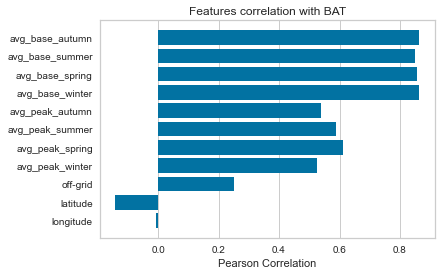

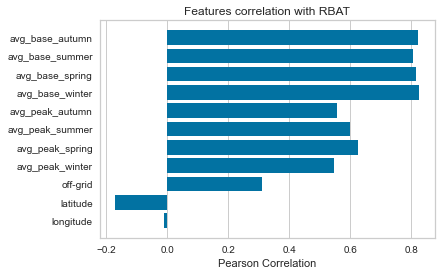

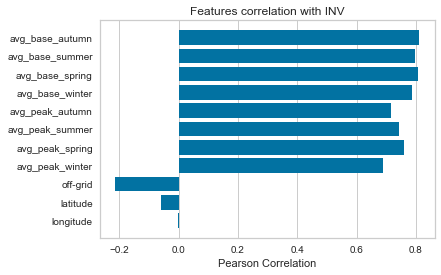

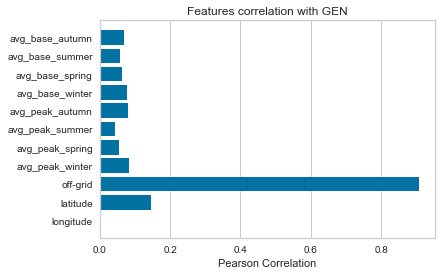

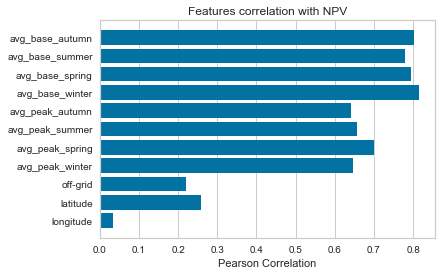

In [4]:
%matplotlib inline
from yellowbrick.target import FeatureCorrelation

for t in targets:
    visualizer = FeatureCorrelation(labels=features, title="Features correlation with "+t)
    visualizer.fit(X, y[t])
    visualizer.show()

## 2. Model Selection

### Split the dataset (Train + validation) - Test 


In [42]:
from sklearn.model_selection import KFold, train_test_split 
from sklearn.preprocessing import StandardScaler

Xscaler = StandardScaler()
yscaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
Xscaler.fit(X_train)
X_train_scale = pd.DataFrame(Xscaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scale = pd.DataFrame(Xscaler.transform(X_test), index=X_test.index, columns=X_test.columns)
yscaler.fit(y_train)
y_train_scale = pd.DataFrame(yscaler.transform(y_train), index=y_train.index, columns=y_train.columns)
y_test_scale = pd.DataFrame(yscaler.transform(y_test), index=y_test.index, columns=y_test.columns)
#X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(X_scale, y_scale, test_size=0.2, random_state=1)

cv = KFold(n_splits=12, random_state=40, shuffle=True)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
X_train_scale

,longitude,latitude,avg_peak_winter,avg_peak_spring,avg_peak_summer,avg_peak_autumn,avg_base_winter,avg_base_spring,avg_base_summer,avg_base_autumn,...,KYTOZIME,LADM,MIRIS,NEW,NRB,PASTI,PELZER,POMMEE,POURDEMAIN,RESA
index,,,,,,,,,,,,,,,,,,,,,
7143,-1.542609,1.052336,1.225635,1.090093,0.890149,1.075370,1.126000,1.154749,1.126720,1.161776,...,-0.232147,-0.22106,-0.225269,-0.223873,-0.230785,-0.238866,4.411929,-0.236197,-0.216785,-0.236197
3627,-1.687787,0.903116,1.141949,0.896411,0.664636,0.848736,1.029389,0.830831,0.700613,0.810180,...,-0.232147,-0.22106,-0.225269,-0.223873,-0.230785,-0.238866,-0.226658,-0.236197,-0.216785,-0.236197
1365,1.185104,0.567783,0.557249,0.737153,1.062629,0.997440,-0.980852,-0.886190,-0.896327,-0.929275,...,-0.232147,-0.22106,-0.225269,-0.223873,-0.230785,-0.238866,-0.226658,-0.236197,-0.216785,-0.236197
4041,-0.912652,1.015356,-2.822824,-2.097470,-1.895425,-2.488516,-1.101911,-0.914771,-0.894794,-1.003042,...,-0.232147,-0.22106,-0.225269,-0.223873,-0.230785,-0.238866,-0.226658,-0.236197,-0.216785,-0.236197
37,0.771534,0.037729,0.803268,0.656682,0.451671,0.559659,1.586936,1.290848,1.169524,1.354198,...,-0.232147,-0.22106,-0.225269,-0.223873,-0.230785,-0.238866,-0.226658,-0.236197,-0.216785,-0.236197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3600,-0.912652,1.015356,1.141949,0.896411,0.664636,0.848736,1.029389,0.830831,0.700613,0.810180,...,-0.232147,-0.22106,-0.225269,-0.223873,-0.230785,-0.238866,-0.226658,-0.236197,-0.216785,-0.236197
3545,0.372038,0.331856,1.141949,0.896411,0.664636,0.848736,1.029389,0.830831,0.700613,0.810180,...,-0.232147,-0.22106,-0.225269,-0.223873,-0.230785,-0.238866,-0.226658,-0.236197,-0.216785,-0.236197
4066,-1.687787,0.903116,-2.822824,-2.097470,-1.895425,-2.488516,-1.101911,-0.914771,-0.894794,-1.003042,...,-0.232147,-0.22106,-0.225269,-0.223873,-0.230785,-0.238866,-0.226658,-0.236197,-0.216785,-0.236197


### 2.1 Regression algorithms supporting multioutput
#### 2.1.1 Hyper parameter tuning

##### Kneighbors (number of neighbors)

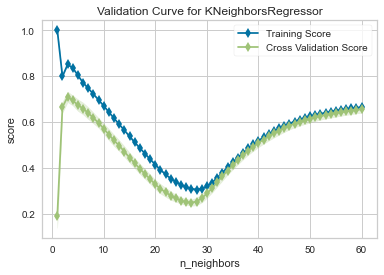

In [43]:
%matplotlib inline
from yellowbrick.model_selection import ValidationCurve

param_range = np.arange(1, 61, 1)
vc = ValidationCurve(KNeighborsRegressor(), param_name="n_neighbors", param_range=param_range, scoring="r2", cv=cv, n_jobs=8)
vc.fit(X_train_scale, y_train_scale)
vc.show();

##### Decision tree (max depth)

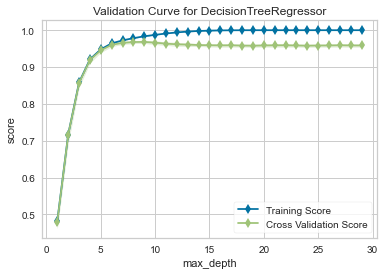

In [26]:
param_range = np.arange(1, 30, 1)
vc = ValidationCurve(DecisionTreeRegressor(), param_name="max_depth", param_range=param_range, scoring="r2", cv=cv, n_jobs=8)
vc.fit(X_train_scale, y_train_scale)
vc.show();

##### Random Forest (number of trees in the forest)

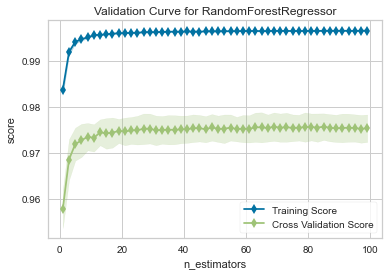

In [27]:
param_range = np.arange(1, 150, 5)
vc = ValidationCurve(RandomForestRegressor(), param_name="n_estimators", param_range=param_range, scoring="r2", cv=cv, n_jobs=8)
vc.fit(X_train_scale, y_train_scale)
vc.show();

##### 2.1.2 Results (Learning Curve, cross-validation scores and predictions)
##### Kneighbors

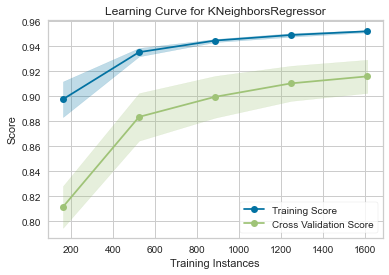

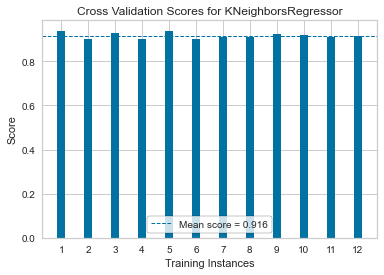

,PV,BAT,RBAT,INV,GEN,NPV
index,,,,,,
4906,0.961938,0.350213,0.454656,0.480969,0.414253,1760.317972
5736,2.472466,2.429023,2.744204,1.236233,0.201374,4936.519222
1325,3.375909,0.552243,0.610535,1.687955,0.000000,4815.472516
5748,2.075379,2.733377,2.585291,1.187634,0.346507,4717.475240
7978,1.322865,0.607909,0.916850,0.802166,0.432847,2875.883828


,PV,BAT,RBAT,INV,GEN,NPV
index,,,,,,
4906,0.931716,0.304077,0.470385,0.544050,0.250928,1443.109614
5736,2.432521,2.644038,2.312070,1.270073,0.228339,4947.128152
1325,3.508313,0.486567,0.471649,1.850373,0.000000,4551.601484
5748,2.389488,2.573030,2.438905,1.299932,0.232513,5094.917492
7978,1.417766,1.265816,1.344200,0.755114,0.302940,3409.864102


Kneighbors test score:  0.9217011565809203


,KNeighbors
PV,0.591603
BAT,0.452688
RBAT,0.445105
INV,0.345337
GEN,0.069708
NPV,916.743885


In [6]:
from yellowbrick.model_selection import LearningCurve, CVScores
from sklearn.metrics import mean_squared_error

Knn = KNeighborsRegressor(n_neighbors=4)
lc = LearningCurve(Knn, scoring='r2', random_state=2, cv=cv, shuffle=True)

lc.fit(X_train_scale, y_train_scale)
lc.show();

cvs = CVScores(Knn, cv=cv, scoring='r2')

cvs.fit(X_train_scale, y_train_scale)
cvs.show();

from IPython.display import display
Knn.fit(X_train_scale, y_train_scale)
y_pred_scale = pd.DataFrame(Knn.predict(X_test_scale), index=y_test.index, columns=y_test.columns)
y_pred = pd.DataFrame(yscaler.inverse_transform(y_pred_scale, copy=True), index=y_test.index, columns=y_test.columns)
display(y_test.head())
display(y_pred.head())
knn_test_score = Knn.score(X_test_scale, y_test_scale)
print("Kneighbors test score: ",knn_test_score)
RMSE_knn = pd.DataFrame(mean_squared_error(y_test, y_pred, multioutput='raw_values', squared=False), index=y_test.columns, columns=["KNeighbors"])
display(RMSE_knn)

##### Decision tree

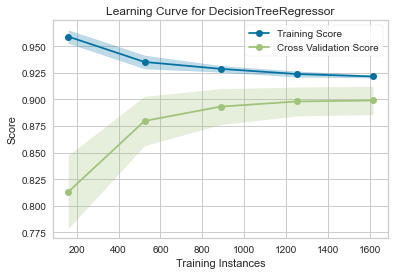

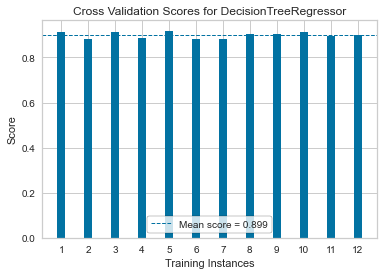

,PV,BAT,RBAT,INV,GEN,NPV
index,,,,,,
4906,0.961938,0.350213,0.454656,0.480969,0.414253,1760.317972
5736,2.472466,2.429023,2.744204,1.236233,0.201374,4936.519222
1325,3.375909,0.552243,0.610535,1.687955,0.000000,4815.472516
5748,2.075379,2.733377,2.585291,1.187634,0.346507,4717.475240
7978,1.322865,0.607909,0.916850,0.802166,0.432847,2875.883828


,PV,BAT,RBAT,INV,GEN,NPV
index,,,,,,
4906,0.940131,0.360755,0.557953,0.583391,1.855382e-01,1536.753304
5736,2.431699,2.634594,2.378926,1.279722,3.165836e-01,5649.206852
1325,3.366271,0.846431,0.872129,1.721655,2.220446e-16,6906.793485
5748,2.431699,2.634594,2.378926,1.279722,3.165836e-01,5649.206852
7978,1.455087,0.725785,0.915395,0.800039,4.923963e-01,3303.253956


Decision Tree test score:  0.9005059820103053


,DecisionTree
PV,0.629672
BAT,0.536291
RBAT,0.517896
INV,0.363778
GEN,0.082418
NPV,1168.640722


In [7]:
Dt = DecisionTreeRegressor(max_depth=6)
lc = LearningCurve(Dt, scoring='r2', random_state=2, cv=cv, shuffle=True)

lc.fit(X_train_scale, y_train_scale)
lc.show();

cvs = CVScores(Dt, cv=cv, scoring='r2')

cvs.fit(X_train_scale, y_train_scale)
cvs.show();


Dt.fit(X_train_scale, y_train_scale)
y_pred_scale = pd.DataFrame(Dt.predict(X_test_scale), index=y_test.index, columns=y_test.columns)
y_pred = pd.DataFrame(yscaler.inverse_transform(y_pred_scale, copy=True), index=y_test.index, columns=y_test.columns)
display(y_test.head())
display(y_pred.head())
dt_test_score = Dt.score(X_test_scale, y_test_scale)
print("Decision Tree test score: ",dt_test_score)
RMSE_dt = pd.DataFrame(mean_squared_error(y_test, y_pred, multioutput='raw_values', squared=False), index=y_test.columns, columns=["DecisionTree"])
display(RMSE_dt)

##### Linear regression

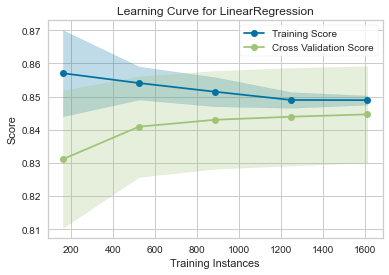

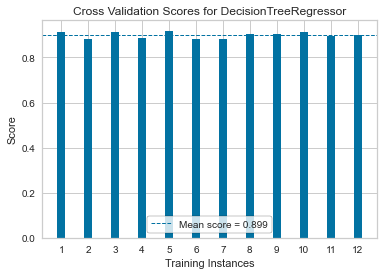

,PV,BAT,RBAT,INV,GEN,NPV
index,,,,,,
4906,0.961938,0.350213,0.454656,0.480969,0.414253,1760.317972
5736,2.472466,2.429023,2.744204,1.236233,0.201374,4936.519222
1325,3.375909,0.552243,0.610535,1.687955,0.000000,4815.472516
5748,2.075379,2.733377,2.585291,1.187634,0.346507,4717.475240
7978,1.322865,0.607909,0.916850,0.802166,0.432847,2875.883828


,PV,BAT,RBAT,INV,GEN,NPV
index,,,,,,
4906,0.952909,1.243786,1.339550,0.546535,0.378069,2608.627624
5736,2.720863,3.100198,2.956436,1.432890,0.407548,6434.746931
1325,3.551316,0.452468,0.643880,1.876554,0.040274,6162.676811
5748,2.721694,3.366878,3.225898,1.475227,0.378699,5552.587287
7978,1.231527,1.706342,1.774103,0.716748,0.407236,1869.808322


Linear regression test score:  0.8544852567416834


,Linear Regression
PV,0.651079
BAT,0.807314
RBAT,0.713686
INV,0.398104
GEN,0.098500
NPV,1540.159883


In [8]:
Lr = LinearRegression()
lc = LearningCurve(Lr, scoring='r2', random_state=2, cv=cv, shuffle=True)

lc.fit(X_train_scale, y_train_scale)
lc.show();

cvs = CVScores(Dt, cv=cv, scoring='r2')

cvs.fit(X_train_scale, y_train_scale)
cvs.show();


Lr.fit(X_train_scale, y_train_scale)
y_pred_scale = pd.DataFrame(Lr.predict(X_test_scale), index=y_test.index, columns=y_test.columns)
y_pred = pd.DataFrame(yscaler.inverse_transform(y_pred_scale, copy=True), index=y_test.index, columns=y_test.columns)
display(y_test.head())
display(y_pred.head())
lr_test_score = Lr.score(X_test_scale, y_test_scale)
print("Linear regression test score: ",lr_test_score)
RMSE_lr = pd.DataFrame(mean_squared_error(y_test, y_pred, multioutput='raw_values', squared=False), index=y_test.columns, columns=["Linear Regression"])
display(RMSE_lr)

###### Random Forest

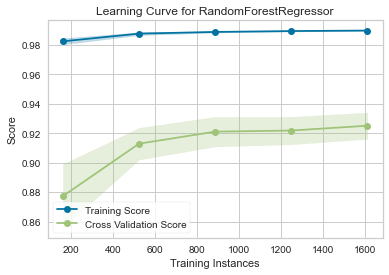

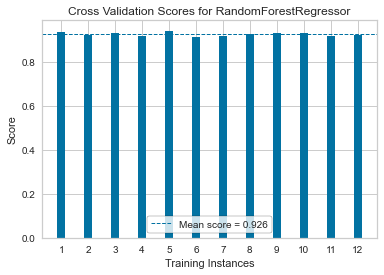

,PV,BAT,RBAT,INV,GEN,NPV
index,,,,,,
4906,0.961938,0.350213,0.454656,0.480969,0.414253,1760.317972
5736,2.472466,2.429023,2.744204,1.236233,0.201374,4936.519222
1325,3.375909,0.552243,0.610535,1.687955,0.000000,4815.472516
5748,2.075379,2.733377,2.585291,1.187634,0.346507,4717.475240
7978,1.322865,0.607909,0.916850,0.802166,0.432847,2875.883828


,PV,BAT,RBAT,INV,GEN,NPV
index,,,,,,
4906,0.980275,0.388551,0.568587,0.571561,0.214782,1651.712877
5736,2.458358,2.530459,2.214651,1.261874,0.255178,5220.962789
1325,2.927605,0.773061,0.730035,1.549460,0.000000,4461.326045
5748,2.330949,2.670430,2.506349,1.288504,0.266883,5239.013115
7978,1.474170,0.763735,0.929968,0.807974,0.453344,2990.021605


Random Forest test score:  0.9308298362883844


,RandomForest
PV,0.595740
BAT,0.375742
RBAT,0.389366
INV,0.327501
GEN,0.066713
NPV,795.132218


In [9]:
Rf = RandomForestRegressor(n_estimators=50)
lc = LearningCurve(Rf, scoring='r2', random_state=2, cv=cv, shuffle=True)

lc.fit(X_train_scale, y_train_scale)
lc.show();

cvs = CVScores(Rf, cv=cv, scoring='r2')

cvs.fit(X_train_scale, y_train_scale)
cvs.show();


Rf.fit(X_train_scale, y_train)
# y_pred_scale = pd.DataFrame(Rf.predict(X_test_scale), index=y_test.index, columns=y_test.columns)
# y_pred = pd.DataFrame(yscaler.inverse_transform(y_pred_scale, copy=True), index=y_test.index, columns=y_test.columns)
y_pred = pd.DataFrame(Rf.predict(X_test_scale), index=y_test.index, columns=y_test.columns)

display(y_test.head())
display(y_pred.head())
rf_test_score = Rf.score(X_test_scale, y_test)
print("Random Forest test score: ",rf_test_score)
RMSE_rf = pd.DataFrame(mean_squared_error(y_test, y_pred, multioutput='raw_values', squared=False), index=y_test.columns, columns=["RandomForest"])
display(RMSE_rf)


##### Neural Network

Epoch 1/1000
17/17 - 1s - loss: 0.7382 - mse: 0.7382 - val_loss: 0.6892 - val_mse: 0.6892
Epoch 2/1000
17/17 - 0s - loss: 0.4300 - mse: 0.4300 - val_loss: 0.6772 - val_mse: 0.6772
Epoch 3/1000
17/17 - 0s - loss: 0.3575 - mse: 0.3575 - val_loss: 0.5706 - val_mse: 0.5706
Epoch 4/1000
17/17 - 0s - loss: 0.3190 - mse: 0.3190 - val_loss: 0.5399 - val_mse: 0.5399
Epoch 5/1000
17/17 - 0s - loss: 0.2724 - mse: 0.2724 - val_loss: 0.4879 - val_mse: 0.4879
Epoch 6/1000
17/17 - 0s - loss: 0.2389 - mse: 0.2389 - val_loss: 0.4530 - val_mse: 0.4530
Epoch 7/1000
17/17 - 0s - loss: 0.2332 - mse: 0.2332 - val_loss: 0.4219 - val_mse: 0.4219
Epoch 8/1000
17/17 - 0s - loss: 0.1969 - mse: 0.1969 - val_loss: 0.3886 - val_mse: 0.3886
Epoch 9/1000
17/17 - 0s - loss: 0.2015 - mse: 0.2015 - val_loss: 0.3457 - val_mse: 0.3457
Epoch 10/1000
17/17 - 0s - loss: 0.1833 - mse: 0.1833 - val_loss: 0.2987 - val_mse: 0.2987
Epoch 11/1000
17/17 - 0s - loss: 0.1622 - mse: 0.1622 - val_loss: 0.2742 - val_mse: 0.2742
Epoch 12

17/17 - 0s - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0672 - val_mse: 0.0672
Epoch 92/1000
17/17 - 0s - loss: 0.0415 - mse: 0.0415 - val_loss: 0.0657 - val_mse: 0.0657
Epoch 93/1000
17/17 - 0s - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0680 - val_mse: 0.0680
Epoch 94/1000
17/17 - 0s - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0678 - val_mse: 0.0678
Epoch 95/1000
17/17 - 0s - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0691 - val_mse: 0.0691
Epoch 96/1000
17/17 - 0s - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0718 - val_mse: 0.0718
Epoch 97/1000
17/17 - 0s - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0695 - val_mse: 0.0695
Epoch 98/1000
17/17 - 0s - loss: 0.0399 - mse: 0.0399 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 99/1000
17/17 - 0s - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 100/1000
17/17 - 0s - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0710 - val_mse: 0.0710
Epoch 101/1000
17/17 - 0s - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0836 - val_mse: 0.0836
Epoch 102/1

Epoch 181/1000
17/17 - 0s - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0644 - val_mse: 0.0644
Epoch 182/1000
17/17 - 0s - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0690 - val_mse: 0.0690
Epoch 183/1000
17/17 - 0s - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 184/1000
17/17 - 0s - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0636 - val_mse: 0.0636
Epoch 185/1000
17/17 - 0s - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0626 - val_mse: 0.0626
Epoch 186/1000
17/17 - 0s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 187/1000
17/17 - 0s - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0621 - val_mse: 0.0621
Epoch 188/1000
17/17 - 0s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0646 - val_mse: 0.0646
Epoch 189/1000
17/17 - 0s - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0646 - val_mse: 0.0646
Epoch 190/1000
17/17 - 0s - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0625 - val_mse: 0.0625
Epoch 191/1000
17/17 - 0s - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0616 - val_

,PV,BAT,RBAT,INV,GEN,NPV
index,,,,,,
4906,0.961938,0.350213,0.454656,0.480969,0.414253,1760.317972
5736,2.472466,2.429023,2.744204,1.236233,0.201374,4936.519222
1325,3.375909,0.552243,0.610535,1.687955,0.000000,4815.472516
5748,2.075379,2.733377,2.585291,1.187634,0.346507,4717.475240
7978,1.322865,0.607909,0.916850,0.802166,0.432847,2875.883828


,PV,BAT,RBAT,INV,GEN,NPV
index,,,,,,
4906,0.805985,0.227144,0.494301,0.483139,0.248967,1641.000366
5736,2.717499,2.533701,2.041791,1.373273,0.233589,5387.255371
1325,3.168435,0.729475,0.537856,1.668172,0.003806,4843.036133
5748,1.916374,2.313380,2.448709,1.091054,0.286197,4791.899414
7978,1.381791,0.823100,1.124971,0.923550,0.287205,3445.840332


,Neural Network
PV,0.493752
BAT,0.404149
RBAT,0.382838
INV,0.272662
GEN,0.070660
NPV,572.441308


Neural Net test score:  0.944216043849062


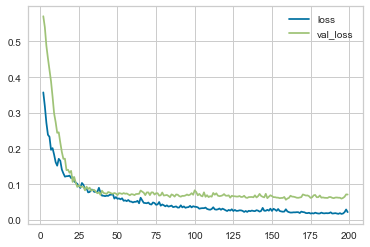

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPU Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=40, # how many epochs to wait before stopping
    restore_best_weights=True,
)

def simple_nn_model():
    model = Sequential([
        Dense(units = 200, input_shape=(len(features),), activation="relu", kernel_initializer='normal'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(units = 400, activation="relu", kernel_initializer='normal'),
        Dense(units = 800, activation="relu", kernel_initializer='normal'),
        #BatchNormalization(),
        Dense(units = 1200, activation="relu", kernel_initializer='normal'),
        Dense(units = 800, activation="relu", kernel_initializer='normal'),
        #Dropout(0.3),
        Dense(units = 600, activation="relu", kernel_initializer='normal'),
        #Dropout(0.3),
        Dense(units = 300, activation="relu", kernel_initializer='normal'),
        #Dropout(0.3),
        #BatchNormalization(),
        Dense(units = 100, activation="relu", kernel_initializer='normal'),
        #Dropout(0.3),
        #BatchNormalization(),
        Dense(units = 6)
    ])
    #model.summary()
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mse'])
    return model
model = simple_nn_model()
#model = tf.keras.models.load_model('nn_model_scaled.h5')
hist = model.fit(x=X_train_scale, y=y_train_scale, batch_size=100, validation_split=1/12, epochs=1000, shuffle=True, verbose=2,callbacks=[early_stopping]) # /!\ Validation set taken before the shuffle
model.save('nn_model_modified4.h5', overwrite=True) #Best nn_model_modified4.h5
history_df = pd.DataFrame(hist.history)
history_df.loc[2:, ['loss', 'val_loss']].plot();
y_pred_scale = pd.DataFrame(model.predict(x=X_test_scale, batch_size=30, verbose=0), index=y_test.index, columns=y_test.columns)
y_pred = pd.DataFrame(yscaler.inverse_transform(y_pred_scale, copy=True), index=y_test.index, columns=y_test.columns)
#y_pred = pd.DataFrame(model.predict(x=X_test_scale, batch_size=10, verbose=0), index=y_test.index, columns=y_test.columns)
RMSE_nn = pd.DataFrame(mean_squared_error(y_test, y_pred, multioutput='raw_values', squared=False), index=y_test.columns, columns=["Neural Network"])
display(y_test.head())
display(y_pred.head())
display(RMSE_nn)
from sklearn.metrics import r2_score

nn_test_score = r2_score(y_test, y_pred)
print("Neural Net test score: ",nn_test_score)

# estimator = KerasRegressor(build_fn=nn_model, epochs=100, batch_size=5, verbose=0)
# results = cross_val_score(estimator, X_train, y_train, cv=cv)
# print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))


##### 2.1.2 Residuals

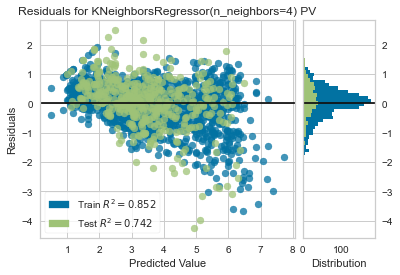

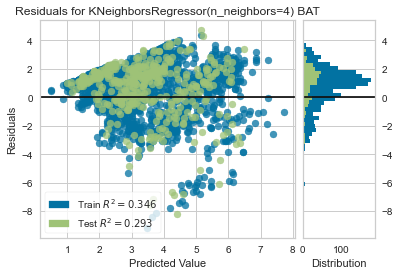

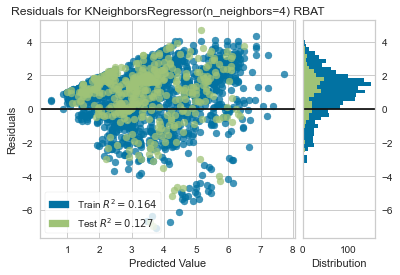

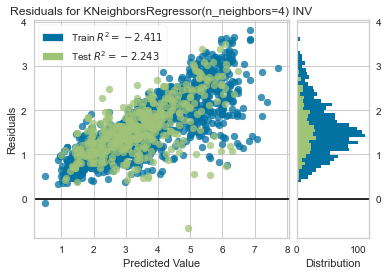

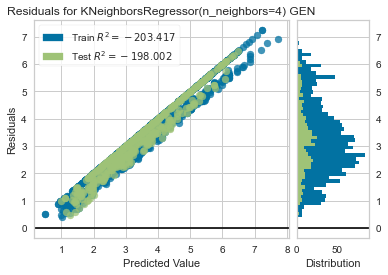

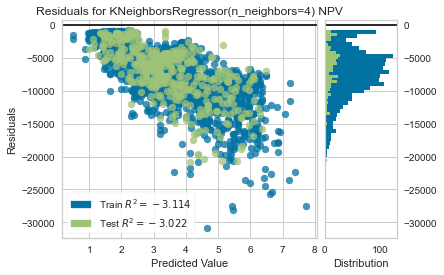

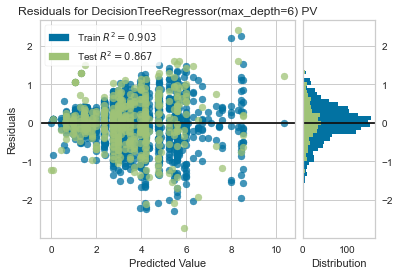

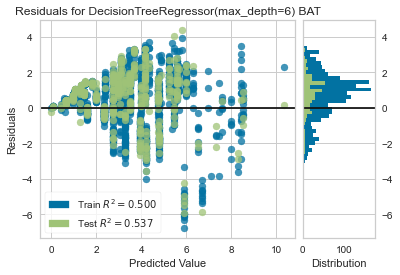

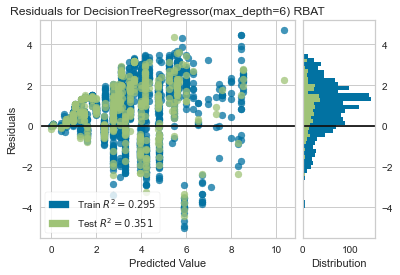

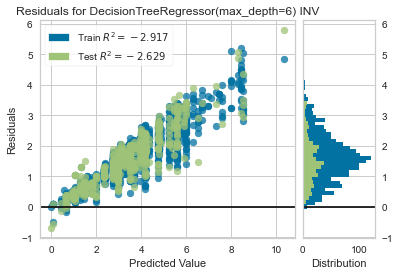

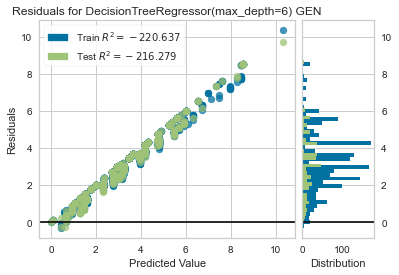

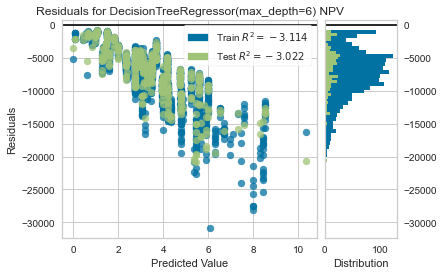

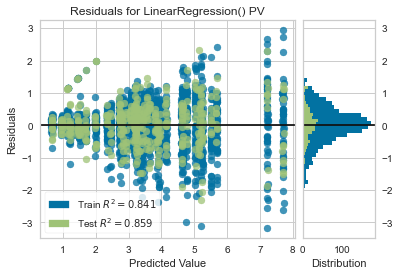

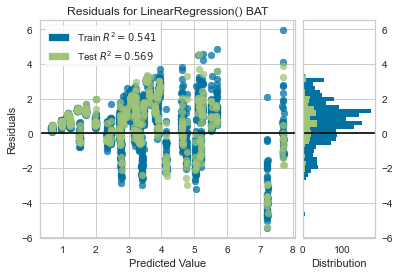

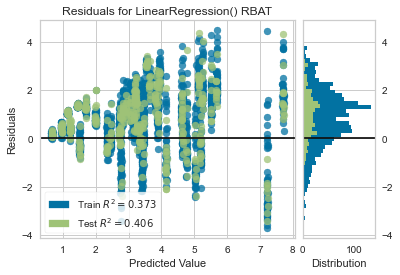

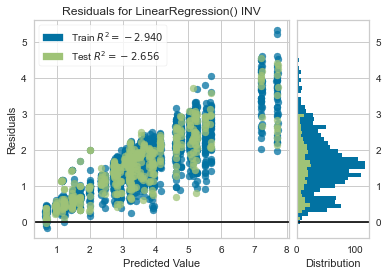

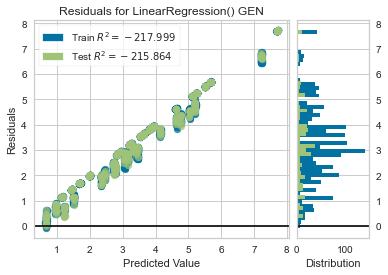

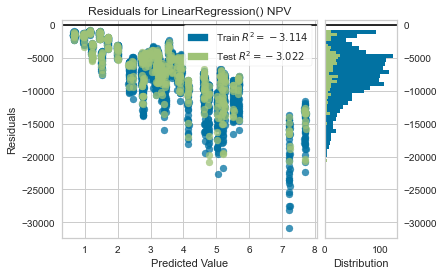

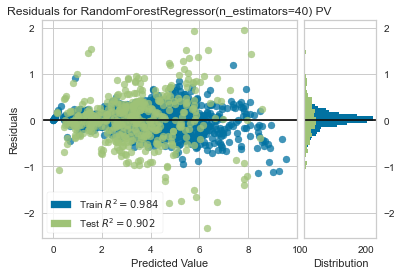

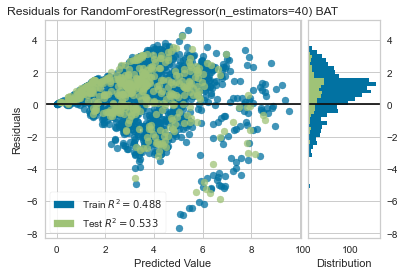

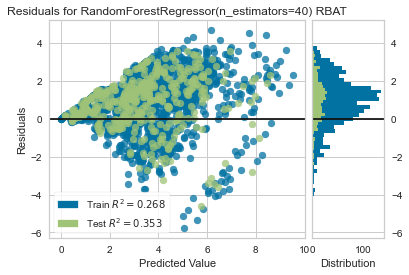

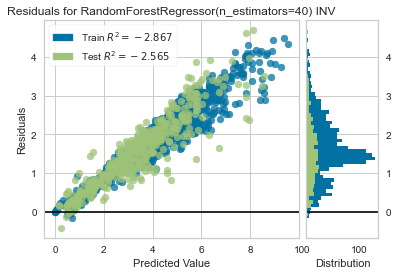

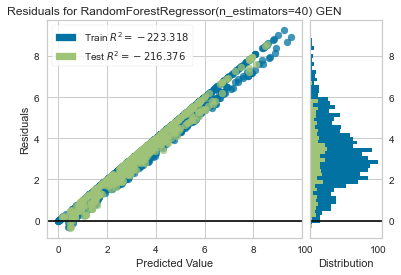

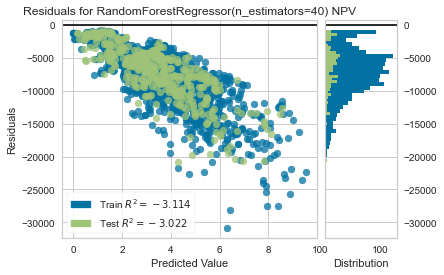

In [42]:
%matplotlib inline
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

models_multi = [KNeighborsRegressor(n_neighbors=4), DecisionTreeRegressor(max_depth=6), LinearRegression(), RandomForestRegressor(n_estimators=40)] 
for m in models_multi:
    for t in targets:
        rp = ResidualsPlot(m, title="Residuals for " + m.__str__() + " "+t )
        rp.fit(X_train, y_train[t])
        rp.score(X_test, y_test[t])  
        rp.show();

#         pe = PredictionError(m, title="Prediction error for " + m.__str__() + " "+ t )
#         pe.fit(X_train, y_train[t])
#         pe.score(X_test, y_test[t])
#         pe.show()

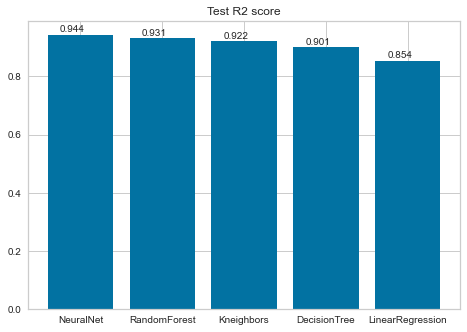

,KNeighbors,DecisionTree,RandomForest,Linear Regression,Neural Network
PV,0.591603,0.629672,0.595740,0.651079,0.493752
BAT,0.452688,0.536291,0.375742,0.807314,0.404149
RBAT,0.445105,0.517896,0.389366,0.713686,0.382838
INV,0.345337,0.363778,0.327501,0.398104,0.272662
GEN,0.069708,0.082418,0.066713,0.098500,0.070660
NPV,916.743885,1168.640722,795.132218,1540.159883,572.441308
Test R2 score,0.921701,0.900506,0.930830,0.854485,0.944216


In [48]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
algs = ['NeuralNet','RandomForest', 'Kneighbors', 'DecisionTree', 'LinearRegression']
scores = [nn_test_score, rf_test_score, knn_test_score, dt_test_score, lr_test_score]
ax.bar(algs,scores)
plt.title('Test R2 score')
for i, v in enumerate(scores):
    plt.text(i - 0.25, v + 0.01, "%.3f"%v)
plt.show()

RMSE = pd.concat([RMSE_knn, RMSE_dt, RMSE_rf, RMSE_lr, RMSE_nn], axis=1)
RMSE.loc["Test R2 score"] = [knn_test_score, dt_test_score, rf_test_score, lr_test_score, nn_test_score]
display(RMSE)

### 2.2 Direct Multi-output

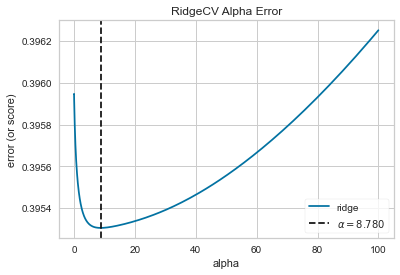

In [279]:
from sklearn.linear_model import RidgeCV
from yellowbrick.regressor import AlphaSelection

alphas = np.logspace(-20, 2, 2000)
Rid = RidgeCV(alphas=alphas)
alselec = AlphaSelection(Rid)
alselec.fit(X_train, y_train["PV"])
alselec.show();

### 2.3 Chained Multi-output

### 2.4 Baseline

In [ ]:
#NPV : recalculer le vrai sur base du sizing obtenu

In [25]:
import sys
#!{sys.executable} -m pip install qgrid


Enabling notebook extension qgrid/extension...
      - Validating: ok
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok
